In [1]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive')

data = pd.read_excel('gdrive/My Drive/Colab Notebooks/Online Retail.xlsx')

data.head()

Mounted at /content/gdrive


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
data = data[data['CustomerID'].notna()]
data = data.sample(10000, random_state = 42)

# **Create The RFM Table**

To make the RFM table, we can create these columns, such as Recency, Frequency, and MonetaryValue column.

- To get the number of days for recency column, we can subtract the snapshot date with the date where the transaction occurred.

- To create the frequency column, we can count how much transactions by each customer.

- Lastly, to create the monetary value column, we can sum all transactions for each customer.

In [3]:
from datetime import datetime
import datetime

data['InvoiceDate'] = data['InvoiceDate'].dt.date

data['Totaltrans'] = data['Quantity'] * data['UnitPrice']

snapshot_date = max(data['InvoiceDate']) + datetime.timedelta(days=1)
rfm_data = data.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - max(x)).days,
                                             'InvoiceNo': 'count',
                                             'Totaltrans': 'sum'})

rfm_data.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Totaltrans': 'MonetaryValue'}, inplace=True)

rfm_data.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,40,5,133.20
12348.0,249,2,120.88
12349.0,19,2,312.75
12352.0,73,5,80.85
12354.0,233,2,33.30


In [4]:
import warnings
warnings.filterwarnings("ignore")

# **Manage Skewness and Scaling**



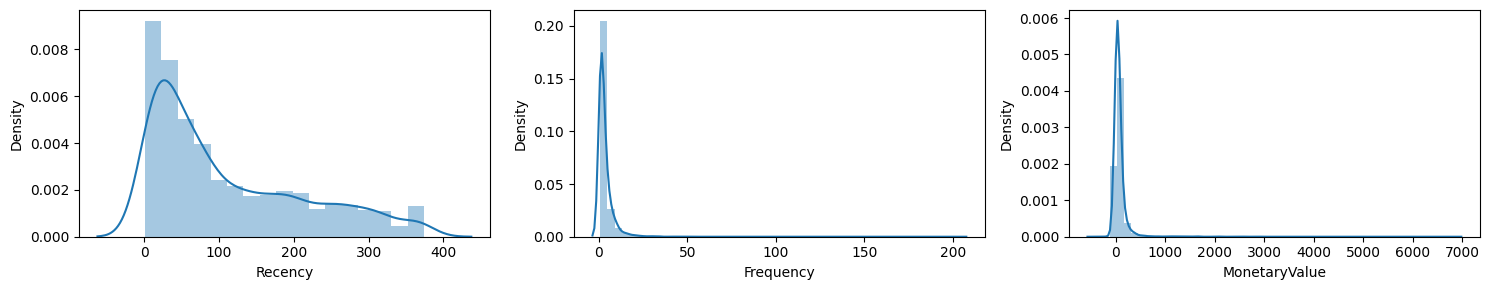

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(rfm_data['Recency'], ax=ax[0])
sns.distplot(rfm_data['Frequency'], ax=ax[1])
sns.distplot(rfm_data['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

As we can see from above, we have to transform the data, so it has a more symmetrical form.

There are some methods that we can use to manage the skewness, they are,

- log transformation
- square root transformation
- box-cox transformation

In [6]:
from scipy import stats
import numpy as np

def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(10,5))
    sns.distplot(rfm_data[x], ax=ax[0,0])
    sns.distplot(np.log(rfm_data[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(rfm_data[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm_data[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(rfm_data[x].skew().round(2))
    print(np.log(rfm_data[x]).skew().round(2))
    print(np.sqrt(rfm_data[x]).skew().round(2))
    print(pd.Series(stats.boxcox(rfm_data[x])[0]).skew().round(2))

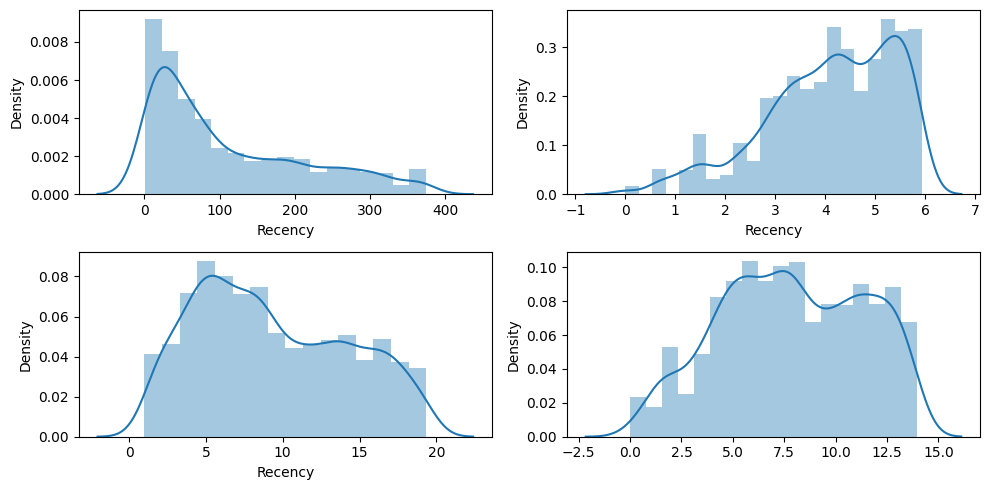

0.93
-0.72
0.32
-0.1


In [7]:
analyze_skewness('Recency')

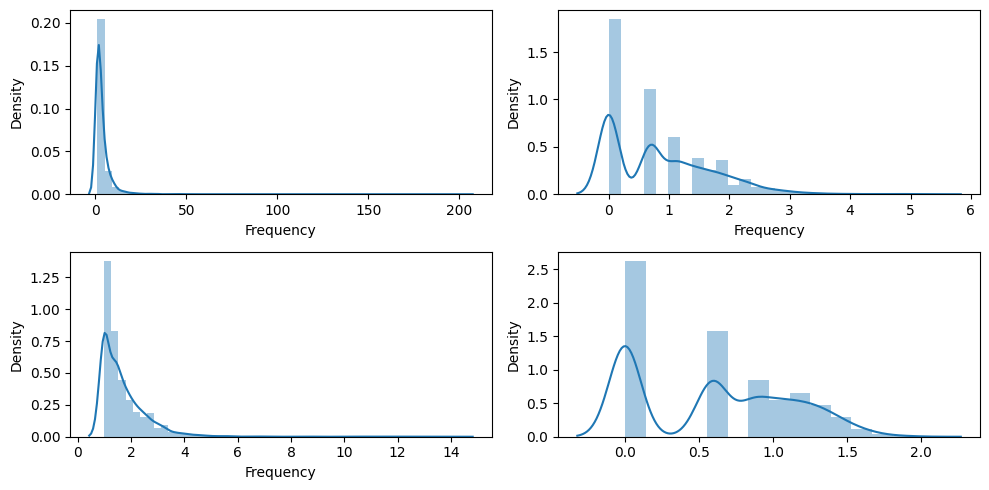

14.77
0.85
3.67
0.16


In [8]:
analyze_skewness('Frequency')

Based on that visualization, it shows that the variables with box-cox transformation shows a more symmetrical form rather than the other transformations. Except for the MonetaryValue variable because the variable includes negative values. To handle this variable, we can use cubic root transformation to the data, so the comparison looks like this,

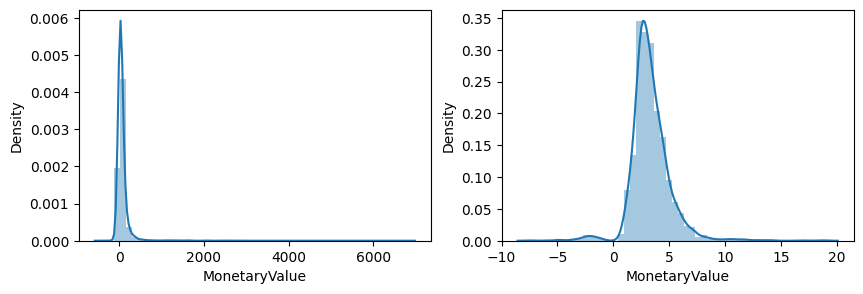

16.63
1.16


In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(rfm_data['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(rfm_data['MonetaryValue']), ax=ax[1])
plt.show()
print(rfm_data['MonetaryValue'].skew().round(2))
print(np.cbrt(rfm_data['MonetaryValue']).skew().round(2))

In [10]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(rfm_data['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(rfm_data['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(rfm_data['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


If we look at the plot once more, each variable don’t have the same mean and variance. We have to normalize it. To normalize, we can use StandardScaler.

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

In [12]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,-0.493794,1.012426,1.017503
1,1.232949,-0.017412,0.925115
2,-0.994917,-0.017412,1.972690
3,-0.012582,1.012426,0.572565
4,1.155005,-0.017412,-0.056441


# **Modelling**

To make segmentation from the data, we can use the K-Means algorithm to do this. To make our clustering reach its maximum performance, we have to determine which hyperparameter fits to the data. To determine which hyperparameter is the best for our model and data, we can use the elbow method to decide.

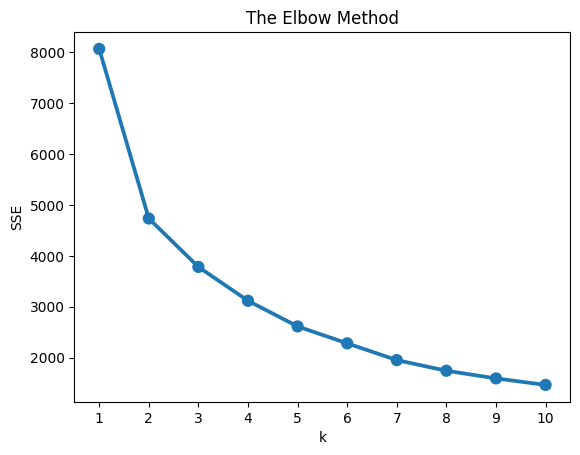

In [14]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Based on our observation, the k-value of 3 is the best hyperparameter for our model because the next k-value tend to have a linear trend. Therefore, our best model for the data is **K-Means with the number of clusters is 3**.

In [15]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2690,)

# **Interpret The Segment**

We can summarize the RFM table based on clusters and calculate the mean of each variable.

In [17]:
rfm_data["Cluster"] = model.labels_
rfm_data.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,40,5,133.20,0
12348.0,249,2,120.88,2
12349.0,19,2,312.75,0
12352.0,73,5,80.85,0
12354.0,233,2,33.30,2


In [18]:
rfm_data.groupby('Cluster').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          46.2       7.7         165.8   924
1          47.6       1.6          21.5   811
2         227.3       1.6          28.7   955

Besides that, we can analyze the segments using **snake plot**. By using this plot, we can have a good visualization from the data on how the cluster differs from each other.

In [30]:
rfm_data.reset_index(inplace=True)
rfm_data.head()

,CustomerID,Recency,Frequency,MonetaryValue,Cluster
0,12347.0,40,5,133.20,0
1,12348.0,249,2,120.88,2
2,12349.0,19,2,312.75,0
3,12352.0,73,5,80.85,0
4,12354.0,233,2,33.30,2


In [22]:
df_nor_melt = pd.melt(rfm_data.reset_index(),
                      id_vars=['CustomerID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,CustomerID,Cluster,Attribute,Value
0,12347.0,0,Recency,40.0
1,12348.0,2,Recency,249.0
2,12349.0,0,Recency,19.0
3,12352.0,0,Recency,73.0
4,12354.0,2,Recency,233.0


<Axes: xlabel='Attribute', ylabel='Value'>

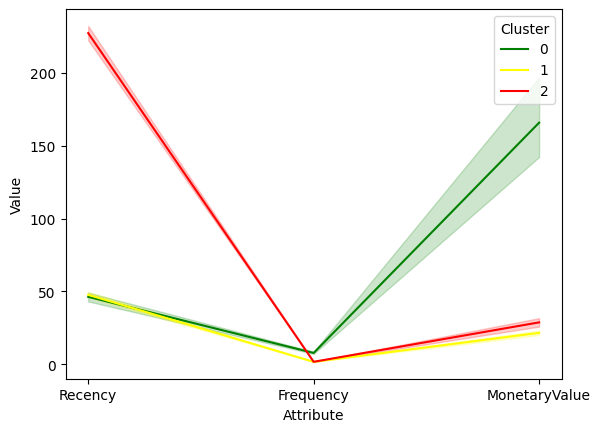

In [29]:
palette = ['Green', 'Yellow', 'Red']
sns.lineplot(data=df_nor_melt, x='Attribute', y='Value', hue='Cluster', palette=palette)

By using this plot, we know how each segment differs. It describes more than we use the summarized table.

- We infer that cluster 0 is frequent, spend more, and they bought the product recently. Therefore, it could be the cluster of a loyal customer.

- Then, the cluster 1 is less frequent, less to spend, but they bought the product recently. Therefore, it could be the cluster of new customer.

- Finally, the cluster 2 is less frequent, less to spend, and they bought the product at the old time. Therefore, it could be the cluster of churned customers.